In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
ny_crime_2013 = pd.read_csv("ny_crime.csv", skiprows=5, names=["city", "population", "violent_crime", "murder", "rape_1",
                                                         "rape_2", "robbery", "aggravated_assult", "property_crime",
                                                         "burglary", "larceny_theft", "motor_vehicle_theft", "arson3"])
ny_crime_2013.head()

,city,population,violent_crime,murder,rape_1,rape_2,robbery,aggravated_assult,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [3]:
ny_crime_2014 = pd.read_excel("ny_crime_2014.xls", skiprows=4, names=["city", "population", "violent_crime", "murder", "rape_1",
                                                         "rape_2", "robbery", "aggravated_assult", "property_crime",
                                                         "burglary", "larceny_theft", "motor_vehicle_theft", "arson3"])
ny_crime_2014.head()

,city,population,violent_crime,murder,rape_1,rape_2,robbery,aggravated_assult,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3
0,Adams Village,1851.0,0.0,0.0,NaN,0.0,0.0,0.0,11.0,1.0,10.0,0.0,0.0
1,Addison Town and Village,2568.0,2.0,0.0,NaN,0.0,1.0,1.0,49.0,1.0,47.0,1.0,0.0
2,Afton Village4,820.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Akron Village,2842.0,1.0,0.0,NaN,0.0,0.0,1.0,17.0,0.0,17.0,0.0,0.0
4,Albany4,98595.0,802.0,8.0,54.0,NaN,237.0,503.0,3888.0,683.0,3083.0,122.0,12.0


## Clean and add features

In [4]:
# Create function that removes the commas from the numerical variables and cast to a float
def data_cleaner(obs):
    obs = str(obs).replace(",", "")
    obs = float(obs)
    return obs

# Create column list for looping through numeric variables
col_names = list(ny_crime_2013.columns)
col_names.remove("city")

# Apply cleaner
for col in col_names:
    ny_crime_2013[col] = ny_crime_2013[col].apply(lambda x: data_cleaner(x))
    ny_crime_2014[col] = ny_crime_2014[col].apply(lambda x: data_cleaner(x))

In [5]:
feature_variables = ["population", "violent_crime", "murder", "robbery", "aggravated_assult"]
target_variable = "property_crime"

ny_crime_2013_features = pd.DataFrame()
ny_crime_2013_features[target_variable] = ny_crime_2013[target_variable]

for feat in feature_variables:
    ny_crime_2013_features[feat] = ny_crime_2013[feat]

ny_crime_2013_features.dropna(inplace=True)
ny_crime_2013_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 6 columns):
property_crime       348 non-null float64
population           348 non-null float64
violent_crime        348 non-null float64
murder               348 non-null float64
robbery              348 non-null float64
aggravated_assult    348 non-null float64
dtypes: float64(6)
memory usage: 19.0 KB


In [6]:
corr_mat = ny_crime_2013_features[feature_variables].corr()
corr_mat

,population,violent_crime,murder,robbery,aggravated_assult
population,1.000000,0.998854,0.986758,0.998469,0.999134
violent_crime,0.998854,1.000000,0.992098,0.999923,0.999942
murder,0.986758,0.992098,1.000000,0.993104,0.990843
robbery,0.998469,0.999923,0.993104,1.000000,0.999742
aggravated_assult,0.999134,0.999942,0.990843,0.999742,1.000000


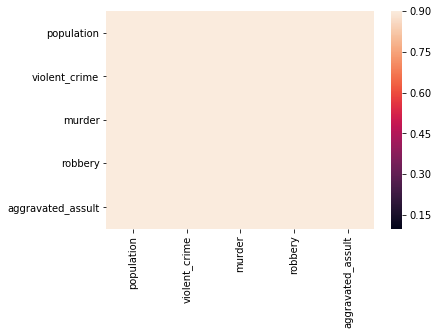

In [7]:
sns.heatmap(corr_mat, vmin=0.1, vmax=0.9)
plt.show()

## Run linear model - attempt #1

In [8]:
linear_formula_1 = target_variable + " ~ " + "+".join(feature_variables)

# Fit the model to our data using the formula.
lm1 = smf.ols(formula=linear_formula_1, data=ny_crime_2013_features).fit()

In [9]:
print("Coefficients")
print(lm1.params.apply(lambda x: format(x, ".2f")))

print("\nP-values")
print(lm1.pvalues.apply(lambda x: format(x, ".5f")))

print("\nR-squared")
print(format(lm1.rsquared, ".5f"))

Coefficients
Intercept             32.87
population             0.01
violent_crime         61.28
murder                13.54
robbery              -61.85
aggravated_assult    -62.61
dtype: object

P-values
Intercept            0.04330
population           0.00000
violent_crime        0.00000
murder               0.47741
robbery              0.00000
aggravated_assult    0.00000
dtype: object

R-squared
0.99900


## Run linear model - attempt #2

In [10]:
feature_variables_2 = ["population", "murder", "robbery", "aggravated_assult"]

In [11]:
linear_formula_2 = target_variable + " ~ " + "+".join(feature_variables_2)

# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula_2, data=ny_crime_2013_features).fit()

In [12]:
print("Coefficients:")
print(lm2.params.apply(lambda x: format(x, ".2f")))

print("\nP-values:")
print(lm2.pvalues.apply(lambda x: format(x, ".5f")))

print("\nR-squared:")
print(format(lm2.rsquared, ".5f"))

Coefficients:
Intercept             90.73
population             0.01
murder               243.76
robbery               -4.73
aggravated_assult      1.83
dtype: object

P-values:
Intercept            0.00001
population           0.00000
murder               0.00000
robbery              0.00016
aggravated_assult    0.01021
dtype: object

R-squared:
0.99840


In [13]:
X = ny_crime_2013_features[feature_variables_2]
Y = ny_crime_2013_features[target_variable]

# Instantiate the model
regr = LinearRegression()
regr.fit(X=X, y=Y)


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.10805385e-02  2.43762884e+02 -4.73130482e+00  1.82585358e+00]

Intercept: 
 90.72997007837284

R-squared:
0.9984019037962545


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
regr = LinearRegression()
regr.fit(X=X_train, y=y_train)
y_pred = regr.predict(X_test)
r2_score(y_test, y_pred)

0.8209790204819934

In [15]:
ny_crime_2014_features = pd.DataFrame()
ny_crime_2014_features[target_variable] = ny_crime_2014[target_variable]

for feat in feature_variables_2:
    ny_crime_2014_features[feat] = ny_crime_2014[feat]

ny_crime_2014_features.dropna(inplace=True)
ny_crime_2014_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 368
Data columns (total 5 columns):
property_crime       368 non-null float64
population           368 non-null float64
murder               368 non-null float64
robbery              368 non-null float64
aggravated_assult    368 non-null float64
dtypes: float64(5)
memory usage: 17.2 KB


In [16]:
ny_crime_2014_features.head()

,property_crime,population,murder,robbery,aggravated_assult
0,11.0,1851.0,0.0,0.0,0.0
1,49.0,2568.0,0.0,1.0,1.0
2,1.0,820.0,0.0,0.0,0.0
3,17.0,2842.0,0.0,0.0,1.0
4,3888.0,98595.0,8.0,237.0,503.0


In [17]:
X_test = ny_crime_2014_features[feature_variables_2]
y_test = ny_crime_2014_features[target_variable]
regr = LinearRegression()
regr.fit(X=X, y=Y)
y_pred = regr.predict(X_test)
r2_score(y_test, y_pred)

0.9801392093810525

In [18]:
cross_val_score(regr, X, Y, cv=10, scoring="r2")

array([ 0.82753743,  0.94153396,  0.08960155,  0.50764646, -0.03380372,
        0.67159617,  0.70406463,  0.94500712,  0.97066088,  0.75772687])

## Run linear model - attempt #3

In [19]:
ny_crime_2013_features["murder_cat"] = ny_crime_2013_features["murder"].apply(lambda x: 1 if x > 0 else 0)
ny_crime_2013_features["robbery_cat"] = ny_crime_2013_features["robbery"].apply(lambda x: 1 if x > 0 else 0)
ny_crime_2013_features["aggravated_assult_cat"] = ny_crime_2013_features["aggravated_assult"].apply(lambda x: 1 if x > 0 else 0)

feature_variables_3 = ["population", "murder_cat", "robbery_cat", "aggravated_assult_cat"]
ny_crime_2013_features.head()

,property_crime,population,violent_crime,murder,robbery,aggravated_assult,murder_cat,robbery_cat,aggravated_assult_cat
0,12.0,1861.0,0.0,0.0,0.0,0.0,0,0,0
1,24.0,2577.0,3.0,0.0,0.0,3.0,0,0,1
2,16.0,2846.0,3.0,0.0,0.0,3.0,0,0,1
3,4090.0,97956.0,791.0,8.0,227.0,526.0,1,1,1
4,223.0,6388.0,23.0,0.0,4.0,16.0,0,1,1


In [20]:
linear_formula_3 = target_variable + " ~ " + "+".join(feature_variables_3)

# Fit the model to our data using the formula.
lm3 = smf.ols(formula=linear_formula_3, data=ny_crime_2013_features).fit()

print("Coefficients:")
print(lm3.params.apply(lambda x: format(x, ".2f")))

print("\nP-values:")
print(lm3.pvalues.apply(lambda x: format(x, ".5f")))

print("\nR-squared:")
print(format(lm3.rsquared, ".5f"))

Coefficients:
Intercept                -41.79
population                 0.02
murder_cat               606.23
robbery_cat              102.10
aggravated_assult_cat     15.02
dtype: object

P-values:
Intercept                0.59178
population               0.00000
murder_cat               0.00000
robbery_cat              0.19261
aggravated_assult_cat    0.87398
dtype: object

R-squared:
0.99345


In [21]:
corr_mat = ny_crime_2013_features[feature_variables_3].corr()
corr_mat

,population,murder_cat,robbery_cat,aggravated_assult_cat
population,1.000000,0.162309,0.064371,0.039212
murder_cat,0.162309,1.000000,0.313271,0.195844
robbery_cat,0.064371,0.313271,1.000000,0.428592
aggravated_assult_cat,0.039212,0.195844,0.428592,1.000000


## Run linear model - attempt #4

In [22]:
feature_variables_4 = ["population", "murder_cat", "robbery_cat"]

In [23]:
linear_formula_4 = target_variable + " ~ " + "+".join(feature_variables_4)

# Fit the model to our data using the formula.
lm4 = smf.ols(formula=linear_formula_4, data=ny_crime_2013_features).fit()

print("Coefficients:")
print(lm4.params.apply(lambda x: format(x, ".2f")))

print("\nP-values:")
print(lm4.pvalues.apply(lambda x: format(x, ".5f")))

print("\nR-squared:")
print(format(lm4.rsquared, ".5f"))

Coefficients:
Intercept      -32.72
population       0.02
murder_cat     607.38
robbery_cat    106.99
dtype: object

P-values:
Intercept      0.53600
population     0.00000
murder_cat     0.00000
robbery_cat    0.13694
dtype: object

R-squared:
0.99345


In [24]:
corr_mat = ny_crime_2013_features[feature_variables_4].corr()
corr_mat

,population,murder_cat,robbery_cat
population,1.000000,0.162309,0.064371
murder_cat,0.162309,1.000000,0.313271
robbery_cat,0.064371,0.313271,1.000000


## Run linear model - attempt #5

In [25]:
ny_crime_2013_features["pop_sq"] = ny_crime_2013_features["population"].apply(lambda x: x**2)
feature_variables_5 = ["pop_sq", "murder_cat", "robbery_cat"]
ny_crime_2013_features.head()

,property_crime,population,violent_crime,murder,robbery,aggravated_assult,murder_cat,robbery_cat,aggravated_assult_cat,pop_sq
0,12.0,1861.0,0.0,0.0,0.0,0.0,0,0,0,3.463321e+06
1,24.0,2577.0,3.0,0.0,0.0,3.0,0,0,1,6.640929e+06
2,16.0,2846.0,3.0,0.0,0.0,3.0,0,0,1,8.099716e+06
3,4090.0,97956.0,791.0,8.0,227.0,526.0,1,1,1,9.595378e+09
4,223.0,6388.0,23.0,0.0,4.0,16.0,0,1,1,4.080654e+07


In [26]:
linear_formula_5 = target_variable + " ~ " + "+".join(feature_variables_5)

# Fit the model to our data using the formula.
lm5 = smf.ols(formula=linear_formula_5, data=ny_crime_2013_features).fit()

print("Coefficients:")
print(lm5.params.apply(lambda x: format(x, ".2f")))

print("\nP-values:")
print(lm5.pvalues.apply(lambda x: format(x, ".5f")))

print("\nR-squared:")
print(format(lm5.rsquared, ".5f"))

Coefficients:
Intercept        40.09
pop_sq            0.00
murder_cat     1184.06
robbery_cat     300.05
dtype: object

P-values:
Intercept      0.60415
pop_sq         0.00000
murder_cat     0.00000
robbery_cat    0.00451
dtype: object

R-squared:
0.98599


In [27]:
X = ny_crime_2013_features[feature_variables_5]
Y = ny_crime_2013_features[target_variable]

# Instantiate the model
regr = LinearRegression()
regr.fit(X=X, y=Y)


print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.99256120e-09 1.18406016e+03 3.00052598e+02]

Intercept: 
 40.08610470544852

R-squared:
0.9859871204030131


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
regr = LinearRegression()
regr.fit(X=X_train, y=y_train)
y_pred = regr.predict(X_test)
r2_score(y_test, y_pred)

0.24467774804167852

In [29]:
cross_val_score(regr, X, Y, cv=10, scoring="r2")

array([ 5.37537196e-01,  1.50364211e-01, -3.30296783e+00, -1.11013886e-01,
       -5.29245898e-01,  4.73421735e-01, -7.28201421e+03,  1.90837479e-01,
        2.43317188e-01,  5.07985153e-01])